In [10]:
from collections import defaultdict
# Classes
class Individual:
    def __init__(self, ind_id):
        self.id = ind_id
        self.vcf_index = None
        self.autism_status = None
        self.sex = None

    def __repr__(self):
        return '%s' % self.id

class Family:

    def __init__(self):
        self.parents_to_children = defaultdict(list) # (mother_id, father_id) -> [child1, child2, ...]
        self.members = {}

    def add_trio(self, child_id, mother_id, father_id, child_autism_status, child_sex):
        if child_id not in self.members:
            self.members[child_id] = Individual(child_id)
            self.members[child_id].autism_status = child_autism_status
            self.members[child_id].sex = child_sex
        child = self.members[child_id]
        if mother_id not in self.members:
            self.members[mother_id] = Individual(mother_id)
        mother = self.members[mother_id]
        if father_id not in self.members:
            self.members[father_id] = Individual(father_id)
        father = self.members[father_id]

        self.parents_to_children[(mother_id, father_id)].append(child_id)

    def add_vcf_index(self, ind_id, vcf_index):
        if ind_id in self.members:
            self.members[ind_id].vcf_index = vcf_index
            
    def get_ordered_member_ids(self):
        ordered_member_ids = []
        for (mother_id, father_id), child_ids in self.parents_to_children.items():
            ordered_member_ids.extend([mother_id, father_id] + child_ids)
        ordered_member_ids = [x for x in ordered_member_ids if self.members[x].vcf_index is not None]
        return ordered_member_ids

    def get_info(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [(self.members[ind_id].autism_status, self.members[ind_id].sex) for ind_id in ordered_member_ids]
    
    def get_vcf_indices(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [self.members[ind_id].vcf_index for ind_id in ordered_member_ids if self.members[ind_id].vcf_index is not None]

In [197]:
import numpy as np

# Mappings
phase_map = {
    (0, 0, 0): (0, 0, 0, 0),
    (0, 0, 1): (0, 0, 0, 0), # non-mendelian
    (0, 0, 2): (0, 0, 0, 0), # non-mendelian
    (0, 1, 0): (0, 0, 0, 1),
    (0, 1, 1): (0, 0, 1, 0),
    (0, 1, 2): (0, 0, 1, 0), # non-mendelian
    (0, 2, 0): (0, 0, 1, 1), # non-mendelian
    (0, 2, 1): (0, 0, 1, 1),
    (0, 2, 2): (0, 0, 1, 1), # non-mendelian
    (1, 0, 0): (0, 1, 0, 0),
    (1, 0, 1): (1, 0, 0, 0),
    (1, 0, 2): (1, 0, 0, 0), # non-mendelian
    (1, 1, 0): (0, 1, 0, 1),
    (1, 1, 1): (0, 0, 0, 0), # unknown phase
    (1, 1, 2): (1, 0, 1, 0),
    (1, 2, 0): (0, 1, 1, 1), # non-mendelian
    (1, 2, 1): (0, 1, 1, 1),
    (1, 2, 2): (1, 0, 1, 1),
    (2, 0, 0): (1, 1, 0, 0), # non-mendelian
    (2, 0, 1): (1, 1, 0, 0),
    (2, 0, 2): (1, 1, 0, 0), # non-mendelian
    (2, 1, 0): (1, 1, 0, 1), # non-mendelian
    (2, 1, 1): (1, 1, 0, 1),
    (2, 1, 2): (1, 1, 1, 0),
    (2, 2, 0): (1, 1, 1, 1), # non-mendelian
    (2, 2, 1): (1, 1, 1, 1), # non-mendelian
    (2, 2, 2): (1, 1, 1, 1),
}


In [14]:
# load data
import time
import gzip
import matplotlib.pyplot as plt

# Pull arguments
vcf_file = 'AU0918.ms1.22.vcf.gz'
#vcf_file = 'v34.MT.vcf.gz'
ped_file = 'v34.forCompoundHet.ped'

start_time = time.time()

# Pull family structure from ped file
families = {}
member_to_family = {}
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, father_id, mother_id = pieces[0:4]
        if fam_id not in families:
            families[fam_id] = Family()
        families[fam_id].add_trio(child_id, mother_id, father_id, 
                                  'Autism' if pieces[5]=='2' else 'Control', 
                                  'Male' if pieces[4]=='1' else 'Female')
        member_to_family[child_id] = fam_id
        member_to_family[mother_id] = fam_id
        member_to_family[father_id] = fam_id
print('Num families:', len(families))

# Pull data from vcf
with gzip.open(vcf_file, 'rt') as f:
    line = next(f)
    while line.startswith('##'):
        line = next(f)

    # Pull header and add vcf indices
    pieces = line.strip().split('\t')
    for i, ind_id in enumerate(pieces[9:]):
        if ind_id in member_to_family:
            families[member_to_family[ind_id]].add_vcf_index(ind_id, i)
    line = next(f)
    
    # Remove families not included in vcf
    families = dict([(i, x) for i, x in families.items() if len(x.get_vcf_indices()) > 0])
    print('Num families with genomic data:', len(families))
    
    # Load genotypes into numpy arrays
    n = len(pieces)-9
    gen_mapping = {b'./.': -1, b'0/0': 0, b'0/1': 1, b'1/0': 1, b'1/1': 2}
    converter = lambda gen:gen_mapping[gen[:3]]
    vcf_indices = range(9, n+9)
    data = np.loadtxt(f, dtype=np.int8, converters=dict(zip(vcf_indices, [converter]*n)), delimiter='\t', usecols=vcf_indices).T

print('Full dataset', data.shape)

Num families: 756
Num families with genomic data: 1
Full dataset (5, 107662)


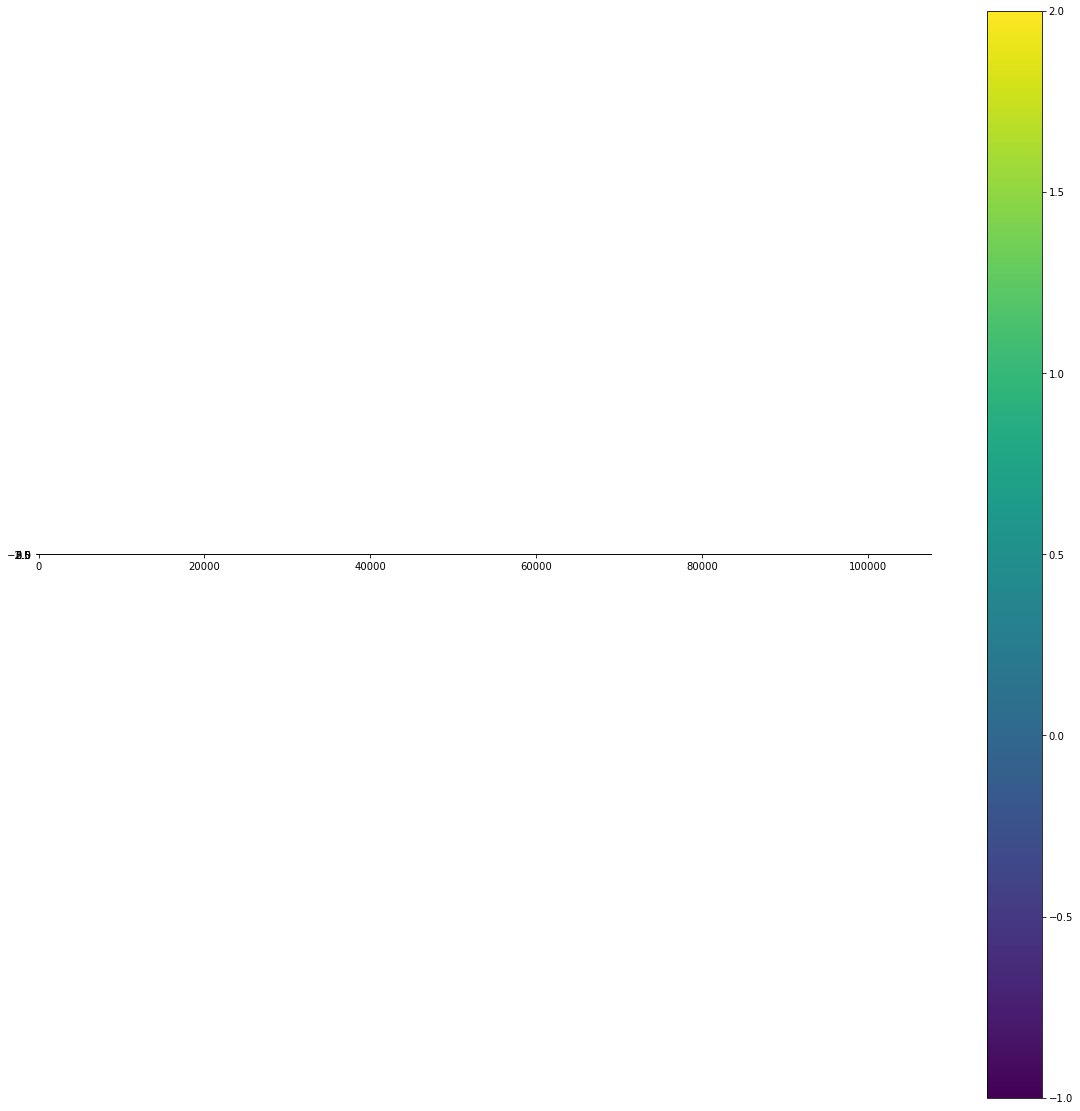

In [15]:
plt.figure(figsize=(20,20))
heatmap = plt.imshow(data)
plt.colorbar(heatmap)
plt.show()

Family AU0918 dataset (5, 107662)
defaultdict(<class 'list'>, {('AU0918202', 'AU0918201'): ['AU0918301', 'AU0918302', 'AU0918303']})
[(None, None), (None, None), ('Autism', 'Male'), ('Autism', 'Female'), ('Autism', 'Male')]
['AU0918202', 'AU0918201', 'AU0918301', 'AU0918302', 'AU0918303']


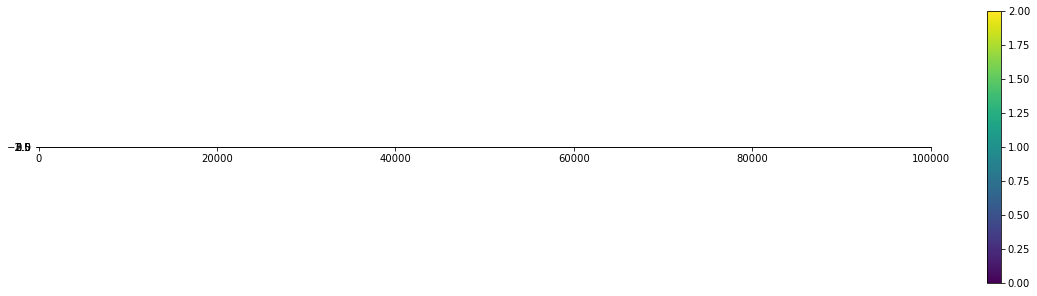

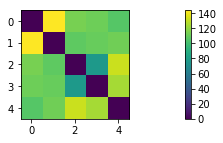

In [17]:
from sklearn.metrics.pairwise import euclidean_distances

for i in range(0, 1):
    family_id, family = list(families.items())[i]
    family_data = data[family.get_vcf_indices(), :]
    print('Family %s dataset' % family_id, family_data.shape)

    print(family.parents_to_children)
    print(family.get_info())
    print(family.get_ordered_member_ids())

    # Remove completely homozygous ref entries
    family_data = family_data[:, ~(family_data==0).all(axis=0)]
    #print('Remove homozygous ref entries', family_data.shape)

    # Remove rows with missing entries
    family_data = family_data[:, (family_data!=-1).all(axis=0)]
    #print('Remove missing entries', family_data.shape)

    plt.figure(figsize=(20,5))
    heatmap = plt.imshow(family_data)
    plt.colorbar(heatmap)
    plt.show()

    d = euclidean_distances(family_data/2, family_data/2)
    plt.figure(figsize=(20,2))
    heatmap = plt.imshow(d)
    plt.colorbar(heatmap)
    plt.show()

In [253]:
from itertools import product


def rough_phase(data, child_index=2, phase_map=phase_map):
    return np.apply_along_axis(lambda x: phase_map[(x[0], x[1], x[child_index])], 0, data)


def phase(data, X, Y):
    m, _, n = X.shape
    all_combinations = np.array(list(product([0, 1], repeat=4))).T
    for i in range(n):
        diff = np.repeat(data[:, i].reshape((m, 1)), 16, axis=1) - X[:, :, i].dot(all_combinations)
        index = np.argmin(np.sum(np.abs(diff), axis=0))
        Y[:, i] = all_combinations[:, index]


def to_genotype(X, Y):
    m, _, n = X.shape
    genotype = np.zeros((m, n), dtype=np.int8)
    for i in range(m):
        genotype[i, :] = np.sum(X[i, :, :]*Y, axis=0)
    return genotype

In [268]:
def detect_recombination(data, X, Y, switch_cost=50):
    m, n = data.shape

    X[0, 0, :] = X[0, 1, :] = 1 # Mom always has m1, m2
    X[1, 2, :] = X[1, 3, :] = 1 # Dad always has p1, p2
    X[2, 0, :] = X[2, 2, :] = 1 # Child1 always has m1, p1

    # genotype possibilities for children
    # m1p1, m1p2, m2p1, m2p2
    Z = np.array([1, 0, 1, 0, 
                  1, 0, 0, 1, 
                  0, 1, 1, 0, 
                  0, 1, 0, 1]).reshape(4, 4).dot(Y)
    transition_costs = np.array([0, 1, 1, 2,
                                 1, 0, 2, 1,
                                 1, 2, 0, 1,
                                 2, 1, 1, 0]).reshape(4, 4)*switch_cost
    index_to_indices = [(0, 2), (0, 3), (1, 2), (1, 3)]
    
    for i in range(3, m):
        # for each child
        
        # Forward sweep
        dp_cost = np.zeros((4, n+1), dtype=np.int)
        dp_arrow = np.zeros((4, n+1), dtype=np.int8)
        dp_arrow[:, 0] = -1

        
        for j in range(n):  
            # costs is a 4x4 matrix representing the cost of transitioning from i -> j         
            costs = np.repeat(dp_cost[:, j].reshape((4, 1)), 4, axis=1) # cost of i
            costs += transition_costs # transition cost
            costs += np.abs(data[i, j] - np.repeat(Z[:, j].reshape((1, 4)), 4, axis=0)) # cost of j

            dp_arrow[:, j+1] = np.argmin(costs, axis=0)
            dp_cost[:, j+1] = np.min(costs, axis=0)
            
        # Backward sweep
        index = n
        k = np.argmin(dp_cost[:, index])
        while index > 0:
            X[i, index_to_indices[k], index-1] = 1
            k = dp_arrow[k, index]
            index -= 1

In [275]:
import time

prev_time = time.time()
Y = rough_phase(family_data)
print('Rough Phase', time.time()-prev_time, 'sec')
Y0 = Y.copy()

m, n = family_data.shape
X = np.zeros((m, 4, n))

prev_time = time.time()
detect_recombination(family_data, X, Y, switch_cost=50)
print('Detect Recomb 1', time.time()-prev_time, 'sec')
X1 = X.copy()

prev_time = time.time()
phase(family_data, X, Y)
print('Phase 1', time.time()-prev_time, 'sec')
Y1 = Y.copy()

#prev_time = time.time()
#detect_recombination(family_data, X, Y, switch_cost=50)
#print('Detect Recomb 2', time.time()-prev_time, 'sec')
#X2 = X.copy()

#prev_time = time.time()
#phase(family_data, X, Y)
#print('Phase 2', time.time()-prev_time, 'sec')
#Y2 = Y.copy()


Rough Phase 2.2121219635009766 sec
Detect Recomb 1 7.7479188442230225 sec
Phase 1 3.234938859939575 sec


In [276]:
m, n = family_data.shape
for j in range(m):
    print(j)
    for X in [X1, X2]:
        maternal_recombinations = [0] + [i for i in range(n-1) if X[j, 0, i] != X[j, 0, i+1]] + [n-1]
        paternal_recombinations = [0] + [i for i in range(n-1) if X[j, 2, i] != X[j, 2, i+1]] + [n-1]
        print(maternal_recombinations)
        print(paternal_recombinations)

0
[0, 100081]
[0, 100081]
[0, 100081]
[0, 100081]
1
[0, 100081]
[0, 100081]
[0, 100081]
[0, 100081]
2
[0, 100081]
[0, 100081]
[0, 100081]
[0, 100081]
3
[0, 11368, 69920, 81484, 100081]
[0, 86317, 100081]
[0, 11368, 69920, 81484, 100081]
[0, 86317, 100081]
4
[0, 11417, 81480, 100081]
[0, 2178, 30849, 100081]
[0, 11417, 81480, 100081]
[0, 2178, 30849, 100081]


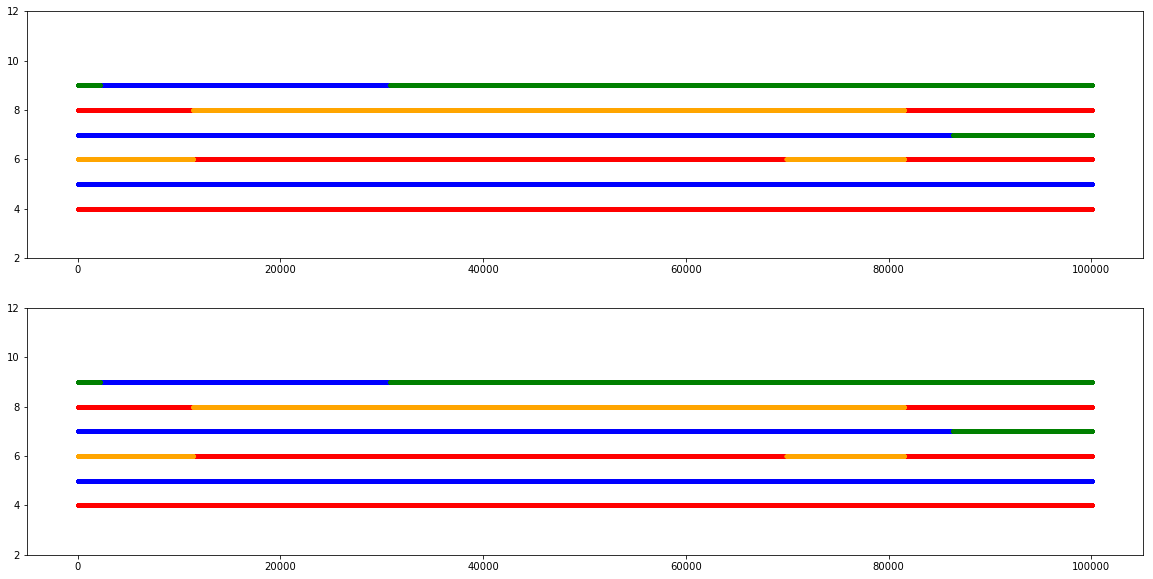

In [277]:
plt.figure(figsize=(20,10))

show = [X1, X2]

for k, X in enumerate(show):
    plt.subplot(len(show), 1, k+1)
    for i in range(2, m):
        plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
        plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
        plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
        plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')
    
    axes = plt.gca()
    axes.set_ylim([2,(m+1)*2])

plt.show()

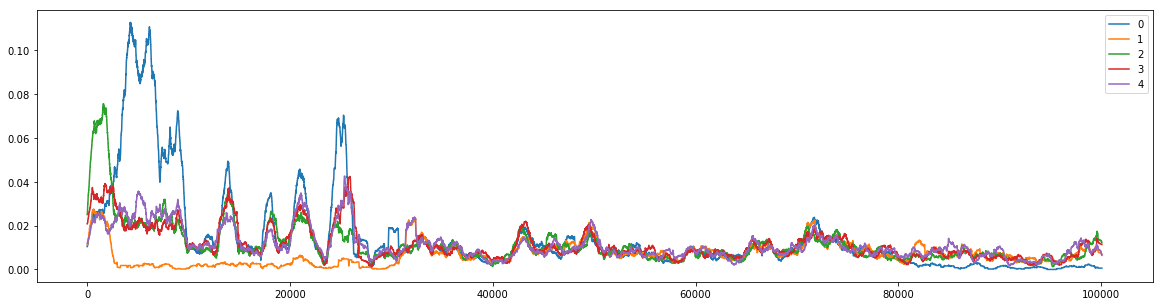

In [278]:
q = 1000
plt.figure(figsize=(20,5))

#plt.plot(np.convolve(np.sum(np.abs(to_genotype(X1, Y1)-data), axis=0)/m, np.ones((q,))/q, mode='same'))
for i in range(m):
    plt.plot(np.convolve(np.abs(to_genotype(X, Y)-family_data)[i, :], np.ones((q,))/(m*q), mode='same'), label=str(i))
axes = plt.gca()
#axes.set_ylim([0, ])
plt.legend()
plt.show()

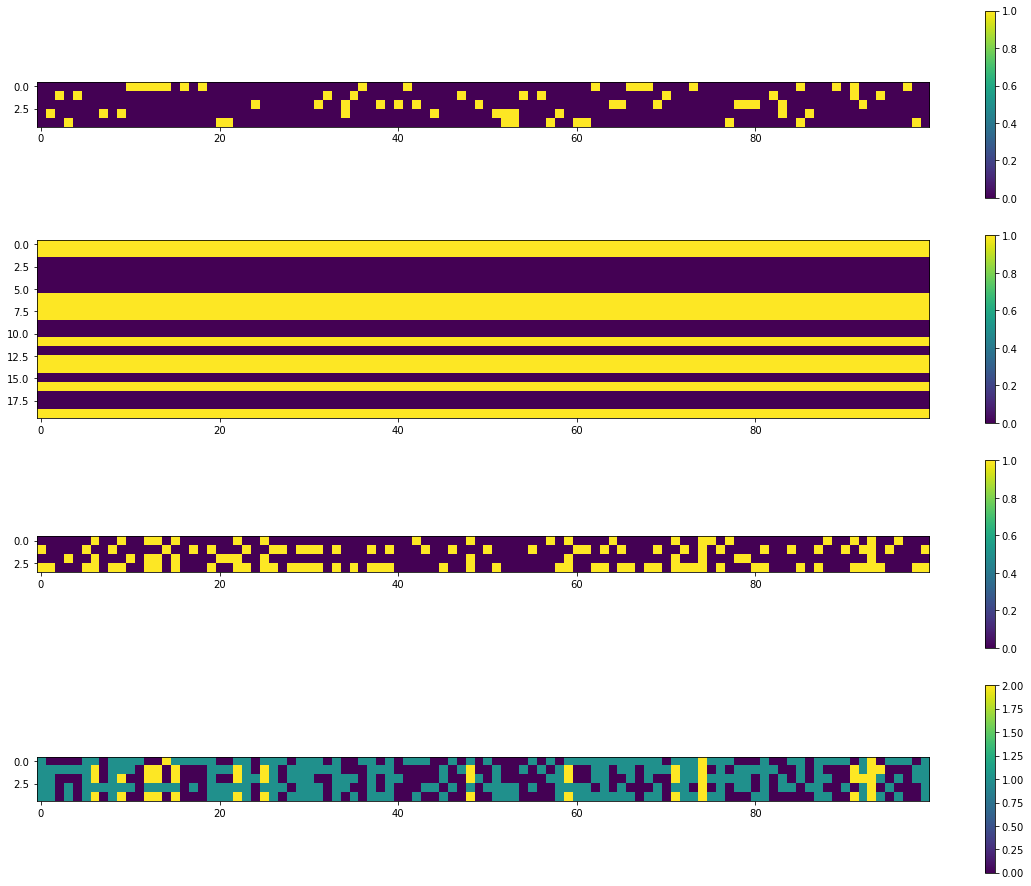

In [101]:
start, end = 1000, 1100
plt.figure(figsize=(20,20))
plt.subplot(5, 1, 2)
heatmap = plt.imshow(X2[:, :, start:end].reshape((m*4, (end-start))))
plt.colorbar(heatmap)
plt.subplot(5, 1, 3)
heatmap = plt.imshow(Y2[:, start:end])
plt.colorbar(heatmap)
plt.subplot(5, 1, 4)
heatmap = plt.imshow(np.abs(family_data)[:, start:end])
plt.colorbar(heatmap)
plt.subplot(5, 1, 1)
heatmap = plt.imshow(np.abs(to_genotype(X2, Y2)-family_data)[:, start:end])
plt.colorbar(heatmap)
plt.show()